(interventional_distribution)=
# Interventional distributions and graph mutation with the do-operator

:::{post} July, 2023
:tags: causal inference, do-operator, graph mutation
:category: beginner, explanation
:author: Benjamin T. Vincent
:::

[PyMC](https://github.com/pymc-devs/pymc) is a pivotal component of the open source Bayesian statistics ecosystem. It helps solve real problems across a wide range of industries and academic research areas every day. And it has gained this level of utility by being accessible, powerful, and practically useful at solving _Bayesian statistical inference_ problems.

But times are changing. There's a [causal revolution](https://en.wikipedia.org/wiki/The_Book_of_Why) underway and there's a growing recognition that to answer some of the most interesting and challenging questions requires us to intergrate causal reasoning into our efforts.

PyMC is rising to this challenge! While there are many novel causal concepts to learn, Bayesians will find that they are not starting from scratch. They are already pretty familiar with [Directed Acyclic Graphs (DAGs)](https://en.wikipedia.org/wiki/Directed_acyclic_graph) and so this gives a good jumping off point to gain relatively easy access into the world of **Bayesian causal inference**.

This notebook is going to cover one of the foundational components of causal reasoning which has newly arrived to the PyMC ecosystem, the $\operatorname{do}$ operator. Indeed, depending on whose definitions you want to use, adding the $\operatorname{do}$ operator into the kind of Bayesian DAGs that PyMC users build every day gets us to the status of building [causal Bayesian networks](https://en.wikipedia.org/wiki/Causal_graph). 

If that sounds cool, let's dive in...

## Set up the notebook

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns

from packaging import version

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


:::{include} ../extra_installs.md
:::

This notebook relies on experimental functionality currently in the [pymc-experimental](https://github.com/pymc-devs/pymc-experimental) repository. In the near future this will be moved into the main [pymc](https://github.com/pymc-devs/pymc) repository.

In [2]:
# import the new functionality
from pymc import do

In [3]:
RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## What can we do with Bayesian inference?

Whether we are building _descriptive_ models or those that try to model the underlying processes, Bayesians are very used to building white box (i.e. the opposite of [black box](https://en.wikipedia.org/wiki/Black_box)), interpretable, models of [data generating processes](https://en.wikipedia.org/wiki/Data_generating_process). While we construct PyMC models using code, behind the scenes this is represented as a DAG, which we can visualise with graphviz. Let's see how this works using the example in the docs:

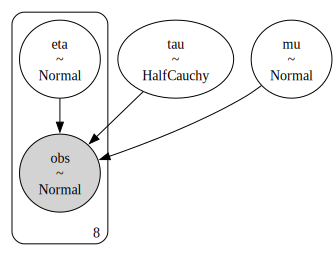

In [4]:
J = 8
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])

with pm.Model() as schools:
    eta = pm.Normal("eta", 0, 1, shape=J)
    mu = pm.Normal("mu", 0, sigma=1e6)
    tau = pm.HalfCauchy("tau", 25)
    theta = mu + tau * eta
    obs = pm.Normal("obs", theta, sigma=sigma, observed=y)

pm.model_to_graphviz(schools)

Regardless of the particular model or models we are working with, we can do a whole range of _statistical_ procedures:

* We could examine the [prior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution#Prior_vs._posterior_predictive_distribution) to see what we'd expect to see in the given DAG based on our stated prior beliefs with `pymc.sample_prior_predictive`. An example use case would be when we want to understand our predictions of how inflation may evolve into the future based on the structure of our model (e.g.  the national and international economy) and our prior beliefs over latent variables.
* We could conduct Bayesian inference by sampling from the posterior distribution with `pymc.sample`. This would update our beliefs to assign credibility to different values of latent variables given the data that we have observed. For example, maybe we get another inflation data point added to our dataset and we want to update our beliefs about the latent variables in the model of the economy.
* We could examine the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution) using `pymc.sample_posterior_predictive`. This is closely related to the prior predictive distribution, but in our running example it would allow us to create a revised set of predictions about future inflation rates after we've observed another data point.
* If we wanted, we could get fancy with {ref}`GLM-model-selection` to compare different models (data generating processes). This could be particularly useful because we arguably don't have complete faith that we know the "true" model of the economy, even at a coarse level of abstraction. So we could build multiple models (DAGs) and evaluate the relative credibility that each model generated the observed data.
* If we have a number of candidate data generating processes, we could incorporate our uncertainty in the data generating process through {ref}`model_averaging`.

If we've mastered all of these steps, we can rightfully feel pretty happy with ourselves. We can accomplish a lot with these statistical and predictive procedures.

## Why causality is important

But now it's time to get smacked in our smug Bayesian face. As others have argued (e.g. {cite:t}`pearl2018why,pearl2000causality`), it is entirely possible to build a pretty good _predictive_ model, but one which can catestrophically fail the moment you (or anyone else) intervenes in the system. Such interventions can totally destroy predictive modelling approaches and wake you up real fast to the necessity of adding causal reasoning into our skillset. 

In our running example, this could correspond to when a central bank switches from making predictions about inflation to now _acting_ and _intervening_ in the system by, for example, changing interest rates. All of a sudden you might be faced with a situation where the economy does not respond to your intervention as you predicted.

Let's consider a seemingly trivial example with 3 nodes to see how we can get fooled. The image below shows two different causal DAGs. On the left we are interested in how $X$ causally affects $Y$, both directly and indirectly through a mediating variable $M$. If we take a purely statistical approach (e.g. {ref}`mediation_analysis`) we might find that the data is very plausibly generated by this DAG. This might give us the confidence to conduct an intervention on $M$ with the aim of influencing our target outcome, $Y$. But when we do this intervention in the real world and change $M$, we actually find absolutely no change in $Y$. What is going on here?

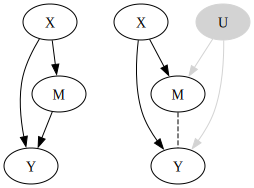

In [5]:
g = gr.Digraph()
# Wrong data generating process
g.node(name="x2", label="X")
g.node(name="y2", label="Y")
g.node(name="m2", label="M")
g.edge(tail_name="x2", head_name="y2")
g.edge(tail_name="x2", head_name="m2")
g.edge(tail_name="m2", head_name="y2")
# Actual causal DAG
g.node(name="x", label="X")
g.node(name="y", label="Y")
g.node(name="m", label="M")
g.node(name="u", label="U", color="lightgrey", style="filled")
g.edge(tail_name="x", head_name="y")
g.edge(tail_name="x", head_name="m")
g.edge(tail_name="m", head_name="y", style="dashed", dir="none")
g.edge(tail_name="u", head_name="m", color="lightgrey")
g.edge(tail_name="u", head_name="y", color="lightgrey")
# Render
g

Little did we know, but the _actual_ data generating process is captured by the DAG on the right. This shows that $X$ does causally influence both $M$ and $Y$, however $M$ does not in fact causally affect $Y$. Instead, there is an unobserved variable $U$ which causally influences both $M$ and $Y$. This unobserved confounder creates a backdoor path in which _statistical_ association may flow between the path $X \rightarrow M \rightarrow U \rightarrow Y$. All this causes a statistical association between $M$ and $Y$ which our purely statistical approach mislead us into thinking that $M$ did causally influence $Y$ when it did not. No wonder our intervention failed to have any effects.

Our mistake was to interpret a statistical model causally.

## Statistical versus interventional distributions
So far this has been quite high-level, but let's try to pin this down a little. In our example, if we were to take a purely statistical approach we could ask "What happened when interest rates were 2%?" This is a statistical question because we are basically looking back in our dataset and filtering (or conditioning) upon time points where interest rates were at (or very close to) 2%. So let's flag up - **conditional distributions are purely statistical quantities**.

Though the real question we might want an answer to is "What would have happened in the past if we had set the interest rates to 2%?" or "What will happen going forward if we set the interest rates to 2%?" Despite the subtle changing of wording, this now radically changes what we have to do in order to answer the question. So a key point here is **interventional distributions require causal (not statistical) approaches**.

Interventional distributions are cool because they allow us to ask what-if (or counterfactual questions). For example, with a causal DAG we could ask questions of the form, "What do I think will happen in the future if I do X?" or "What do I think would have happened in the past if X had happened?" See how these types of questions have a very different flavour to purely statistical kinds of questions - they would be more like "Given what I've seen, what do I think will happen." See how this has a more passive, observational focus.

From hereon, the main point of this notebook will be to provide some understanding and intuition about the differences between conditional and interventional distributions, and how to estimate interventional distributions with PyMC. As we said above, we can use the $\operatorname{do}$ operator to estimate interventional distributions. So let's dive in and see how that works.

## Interventions and the $\operatorname{do}$ operator

We'll consider an example from {cite:t}`pearl2000causality` where we examine a DAG which is a putative causal explanation of how various factors influence each other to result in grass becoming slippery. The left shows our causal DAG, and the right shows how the DAG is changed if we consider an intervention (hypothetical or actual) where we turn the sprinkler on. The $\operatorname{do}$ operator implements an intervention that we want to make. It consists of 2 simple steps:

1. It takes a given node in a graph and sets that node at the desired value.
2. It removes any causal influence on this node by other nodes. It does this by removing all incoming edges into that node.

![](sprinkler.png)

On the left of the figure we have a causal DAG describing the causal relationships between season, whether a sprinkler has been on, whether it has rained, if the grass is wet, and if the grass is slippery. 

The joint distribution can be factorised as: 

$$
P(x_1, x_2, x_3, x_4, x_5) = P(x_1) P(x_3|x_1) P(x_2|x_1) P(x_4|x_3, x_2) P(x_5|x_4)
$$

```{card} Factorizing joint distributions
For a DAG, a complex joint distribution can be broken down into the product of conditional distributions:

$$
P(x_1, x_2, \ldots, x_n) = \prod_i P(x_i|pa_i)
$$

where $pa_i$ are the parents of node $x_i$, and $i = \{ 1, \ldots, n \}$.
```

On the right of the figure we have applied the $\operatorname{do}$ operator to examine what will happen if we set the sprinkler to be on. You can see that we have now set the value of that node, $x_3=1$ and we have removed the incoming edge (influence) of season, meaning that once we turn on the sprinkler manually, it's not influenced by the season anymore.

In order to describe this new interventional distribution we need truncated factorization:

```{card} Truncated factorization
{cite:t}`pearl2000causality` describes truncated factorization as follows. If we have a probability distribution $P(v)$ on a set of $V$ variables, then $P_x(v)$ is the interventional distribution that results from $\operatorname{do}(X=x)$ that sets a subset of $X$ variables to constants $x$. Then we can describe the interventional distribution with truncated factorization as:

$$
P_x(v) = \prod_{ \{ i | V_i \notin X \} } P(v_i|pa_i)
$$

This is actually quite simple. It can be thought of as exactly the same as the regular factorization of the joint distribution, but we are only including terms which do _not_ influence any intervened upon variable.

Interested readers are referred to section 1.3 of {cite:t}`pearl2000causality` on Causal Bayesian Networks.
```

Applying that to the spinkler example, we can define the _interventional distribution_ as:

$$
P(x_1, x_2, \operatorname{do}(x_3=1), x_4, x_5) = P(x_1) P(x_2|x_1) P(x_4|x_3=1, x_2) P(x_5|x_4)
$$

There are two important changes here:
1. Note that $x_3$ was previously a random variable, but this has now been 'locked' at a particular value, $x_3=1$, because of our intervention.
2. Note the absense of the $P(x_3|x_1)$ term, because $x_1$ no longer has any causal influence over $x_3$.

So in summary, this is pretty cool. We can use the $\operatorname{do}$ operator to make in intervention in our model of the world. We can then observe the consequences of this intervention and make much better predictions of what will happen when we are active and intervene (actually or hypothetically) in the world. The accuracy is of course subject to how well our causal DAG reflects the real processes in the world.

For those wanting further background information on the $\operatorname{do}$ operator, explained from a different angle, readers should check out the richly diagrammed and well-explained blog post [Causal Effects via the Do-operator](https://towardsdatascience.com/causal-effects-via-the-do-operator-5415aefc834a) {cite:p}`Talebi2022dooperator`, the popular science book by {cite:t}`pearl2018why`, or the textbook by {cite:t}`molak2023ciadip`.

## Three different causal DAGs

:::{note}
This section takes heavy inspiration from the post [Causal Inference 2: Illustrating Interventions via a Toy Example](https://www.inference.vc/causal-inference-2-illustrating-interventions-in-a-toy-example/) {cite:p}`Huszár2019causal2`. Imitation is the sincerest form of flattery.
:::

If we think about how 2 variables, $x$ and $y$, are related we can come up with many different causal DAGs. Below we consider just 3 possibilities, which we'll label DAG 1, 2, and 3.

1. $x$ causally influences $y$
2. $y$ causally influences $x$
3. $z$ causally influences both $x$ and $y$

We can draw these more graphically below:

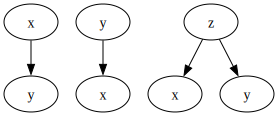

In [6]:
g = gr.Digraph()

# DAG 1
g.node(name="x1", label="x")
g.node(name="y1", label="y")
g.edge(tail_name="x1", head_name="y1")

# DAG 2
g.node(name="y2", label="y")
g.node(name="x2", label="x")
g.edge(tail_name="y2", head_name="x2")

# DAG 3
g.node(name="z", label="z")
g.node(name="x", label="x")
g.node(name="y", label="y")
g.edge(tail_name="z", head_name="x")
g.edge(tail_name="z", head_name="y")

g

We can also imagine implementing such causal DAGs in Python code to generate `N` random numbers. Each of these will give rise to specific joint distributions, $P(x, y)$, and in fact, because Ferenc Huszár was clever in his blog post, we'll see later that these will all give rise to the same joint distributions.

**DAG 1**

```{code-block} python
x = rng.normal(loc=0, scale=1, size=N)
y = x + 1 + np.sqrt(3) * rng.normal(size=N)
```

**DAG 2**

```{code-block} python
y = 1 + 2 * rng.normal(size=N)
x = (y - 1) / 4 + np.sqrt(3) * rng.normal(size=N) / 2
```

**DAG 3**

```{code-block} python
z = rng.normal(size=N)
y = z + 1 + np.sqrt(3) * rng.normal(size=N)
x = z
```

:::{note}
These code snippets are important because they define identical joint distributions $P(x,y)$ but they have different DAG structures. Therefore they may respond differently when it comes to making an intervention with the $\operatorname{do}$ operator. It is worth referring back to these code snippets to make sure you understand how they relate to the DAG structures above and to think through how making interventions on variables will affect the values of each of the variables $x, y, z$ if at all.
:::

However, we are going to implement these using Bayesian causal DAGs with PyMC. Let's see how we can do this, then generate samples from them using `pm.sample_prior_predictive`. As we go with each DAG, we'll extract the samples for plotting later, and also plot the graphviz representation of the PyMC models. You'll see that while these are a fraction more visually complex, they do actually match up with the causal DAGs we've specified above.

In [7]:
# number of samples to generate
N = 1_000_000

Sampling: [temp, x]


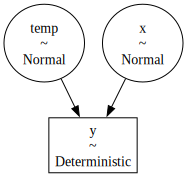

In [8]:
with pm.Model() as model1:
    x = pm.Normal("x")
    temp = pm.Normal("temp")
    y = pm.Deterministic("y", x + 1 + np.sqrt(3) * temp)
    idata1 = pm.sample_prior_predictive(samples=N, random_seed=rng)

ds1 = az.extract(idata1.prior, var_names=["x", "y"])

pm.model_to_graphviz(model1)

Sampling: [temp, y]


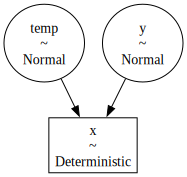

In [9]:
with pm.Model() as model2:
    y = pm.Normal("y", mu=1, sigma=2)
    temp = pm.Normal("temp")
    x = pm.Deterministic("x", (y - 1) / 4 + np.sqrt(3) * temp / 2)
    idata2 = pm.sample_prior_predictive(samples=N, random_seed=rng)

ds2 = az.extract(idata2.prior, var_names=["x", "y"])

pm.model_to_graphviz(model2)

Sampling: [temp, z]


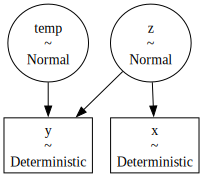

In [10]:
with pm.Model() as model3:
    z = pm.Normal("z")
    temp = pm.Normal("temp")
    y = pm.Deterministic("y", z + 1 + np.sqrt(3) * temp)
    x = pm.Deterministic("x", z)
    idata3 = pm.sample_prior_predictive(samples=N)

ds3 = az.extract(idata3.prior, var_names=["x", "y"])

pm.model_to_graphviz(model3)

### Joint distributions, $P(x,y)$

First, let's take a look at the joint distributions for each of the DAGs to convince ourselves that these are actually the same.

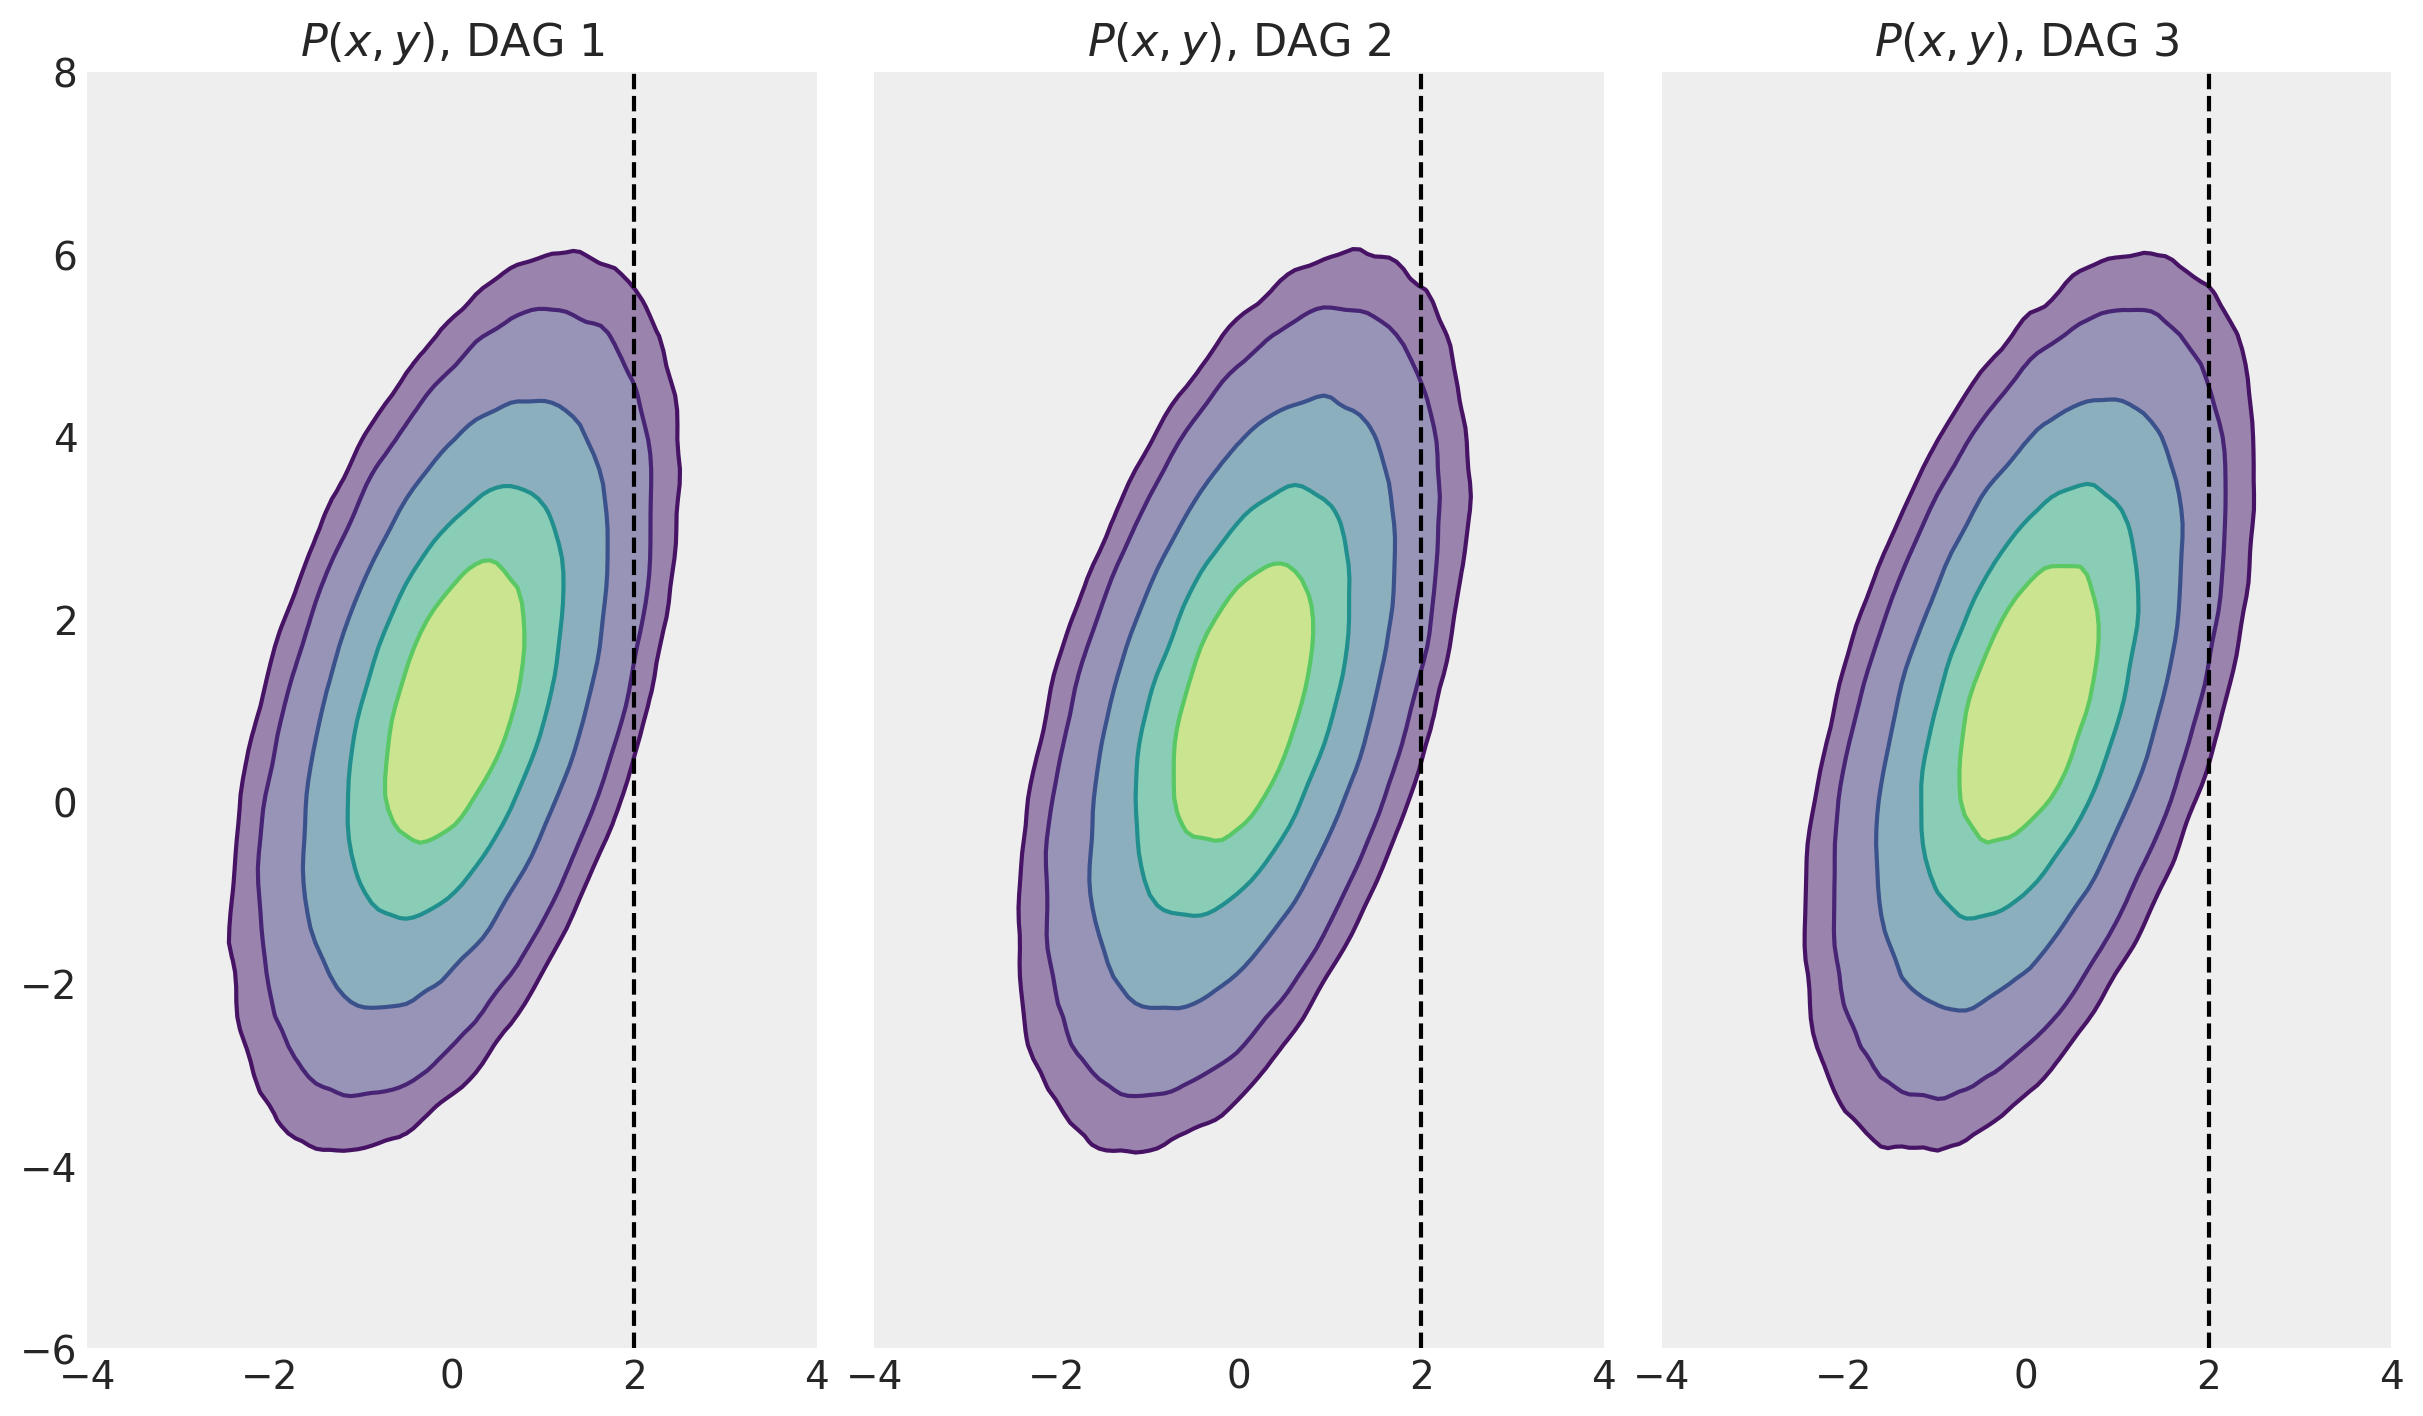

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, ds in enumerate([ds1, ds2, ds3]):
    az.plot_kde(
        ds["x"],
        ds["y"],
        hdi_probs=[0.25, 0.5, 0.75, 0.9, 0.95],
        contour_kwargs={"colors": None},
        contourf_kwargs={"alpha": 0.5},
        ax=ax[i],
    )
    ax[i].set(
        title=f"$P(x, y)$, DAG {i+1}",
        xlim=[-4, 4],
        xticks=np.arange(-4, 4 + 1, step=2),
        ylim=[-6, 8],
        yticks=np.arange(-6, 8 + 1, step=2),
        aspect="equal",
    )
    ax[i].axvline(x=2, ls="--", c="k")

At this point we have met 3 different data generating processes (and their corresponding DAGs). We've drawn many MCMC samples from the prior distribution and visualised this joint distribution $P(x,y)$ for each of the models. We are now in position to recap the conditional distributions (e.g. $P(y|x=2$, see the next section) and how they compare to the interventional distribution $P(y|\operatorname{do}=2)$ in the section following that.

### Conditional distributions, $P(y|x=2)$

In the MCMC spirit of representing probability distributions by samples, let's now calculate the conditional distributions. If we picked all the values where $x$ was _exactly_ 2, then we might not end up with any samples at all, so what we'll do is to take a very narrow slice of samples around 2. So these will be approximations - as the number of samples increases and the width of the slice decreases, then our approximation would become more accurate.

In [12]:
# Extract samples from P(y|x≈2)
conditional1 = ds1.query(sample="1.99 < x < 2.01")["y"]
conditional2 = ds2.query(sample="1.99 < x < 2.01")["y"]
conditional3 = ds3.query(sample="1.99 < x < 2.01")["y"]

So now we've got our MCMC estimates of $P(y|x=2)$ for all of the DAGs. But you're going to have to wait just a moment before we plot them. Let's move on to calculate $P(y|\operatorname{do}(x=2))$ and then plot them in one go so we can compare.

### Interventional distributions, $P(y|\operatorname{do}(x=2))$

In turn for each of the 3 DAGs, let's use the $\operatorname{do}$ operator, setting $x=2$. This will give us a new DAG and we'll plot the graphviz representation and then take samples to represent the interventional distribution.

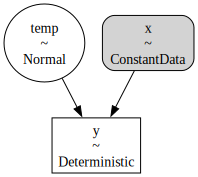

In [13]:
model1_do = do(model1, {"x": 2})
pm.model_to_graphviz(model1_do)

:::{important}
Let's just take a moment to reflect on what we've done here! We took a model (`model1`) and then used the $\operatorname{do}$ function and specified an intervention we wanted to make. In this case it was to set $x=2$. We then got back a new model where the original DAG has been mutated in the way that we set out above. Namely, we defined $x=2$ _and_ removed edges from incoming nodes to $x$. In this first DAG, there were no incoming edges, but this is the case in DAG2 and DAG 3 below.
:::

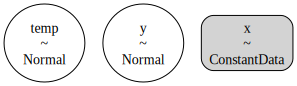

In [14]:
model2_do = do(model2, {"x": 2})
pm.model_to_graphviz(model2_do)

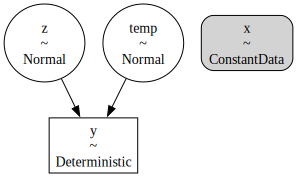

In [15]:
model3_do = do(model3, {"x": 2})
pm.model_to_graphviz(model3_do)

So we can see that in DAG 1, the $x$ variable still has causal influence on $y$. However, in DAGs 2 and 3, $y$ is no longer causally influenced by $x$. So in DAGs 2 and 3, our intervention $\operatorname{do}(x=2)$ have no influence on $y$.

Next we'll sample from each of these interventional distributions. Note that we are using the mutilated models, `model1_do`, `model2_do`, and `model3_do`. 

In [16]:
with model1_do:
    idata1_do = pm.sample_prior_predictive(samples=N, random_seed=rng)

with model2_do:
    idata2_do = pm.sample_prior_predictive(samples=N, random_seed=rng)

with model3_do:
    idata3_do = pm.sample_prior_predictive(samples=N, random_seed=rng)

Sampling: [temp]
Sampling: [temp, y]
Sampling: [temp, z]


So let's compare the conditional and interventional distributions for all 3 DAGs.

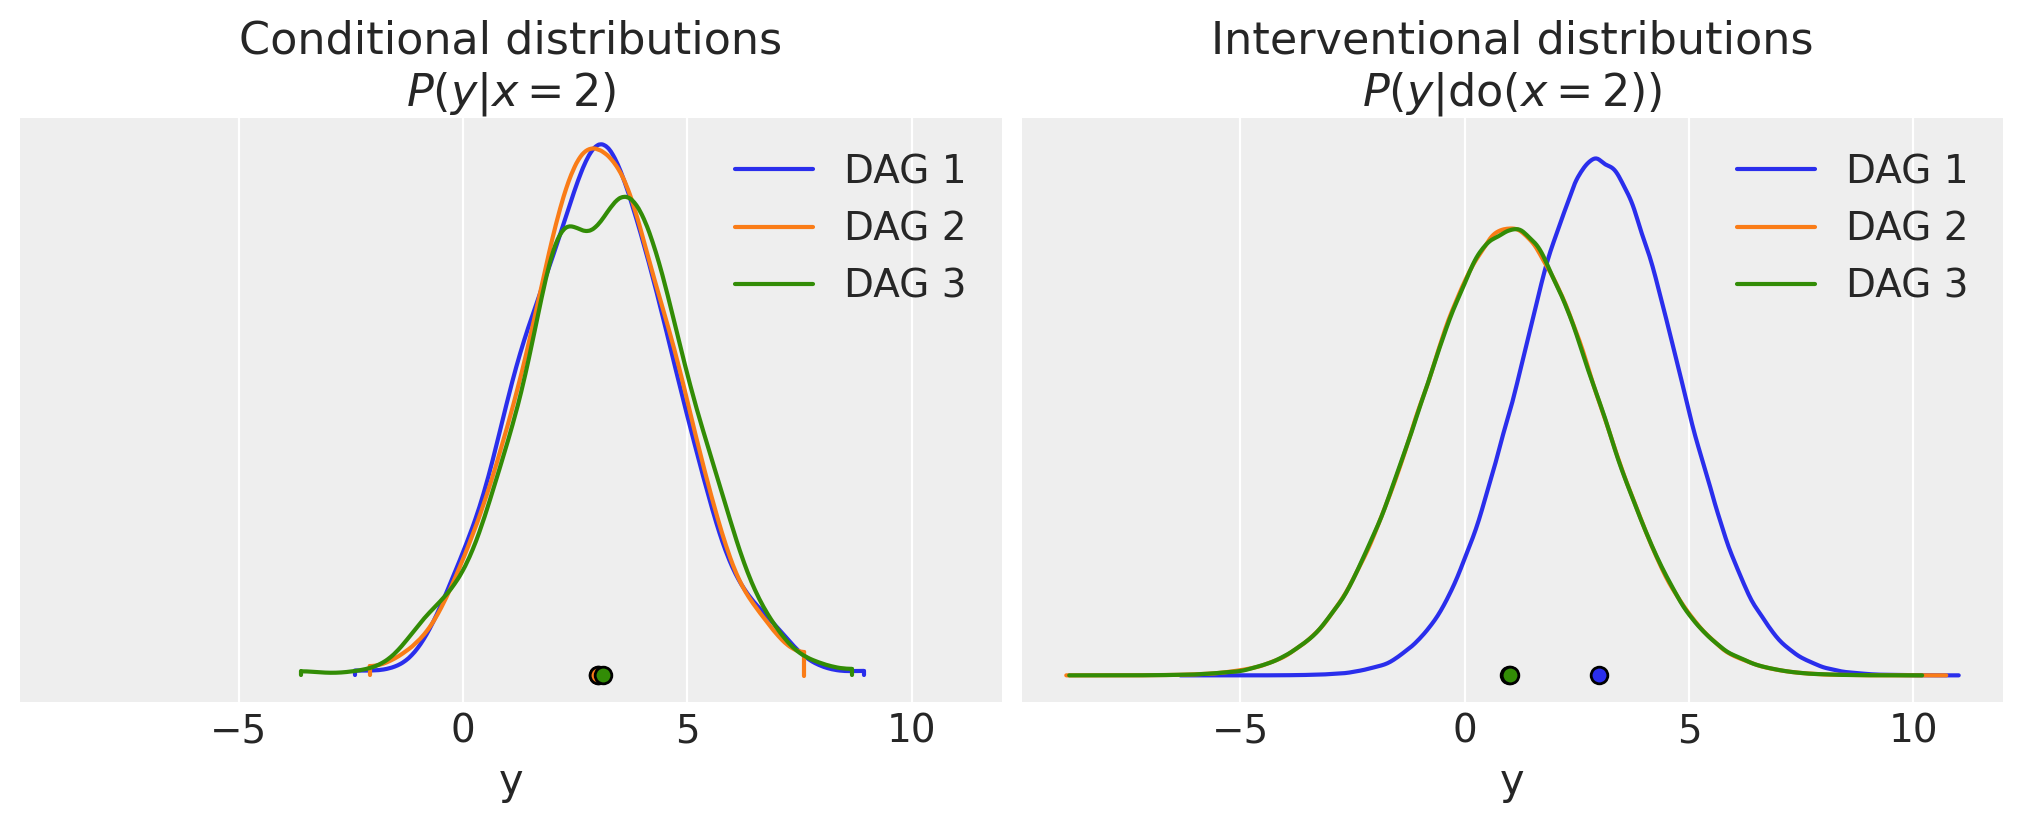

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

az.plot_density(
    [conditional1, conditional2, conditional3],
    data_labels=["DAG 1", "DAG 2", "DAG 3"],
    combine_dims={"sample"},
    ax=ax[0],
    hdi_prob=1.0,
)
ax[0].set(xlabel="y", title="Conditional distributions\n$P(y|x=2)$")

az.plot_density(
    [idata1_do, idata2_do, idata3_do],
    data_labels=["DAG 1", "DAG 2", "DAG 3"],
    group="prior",
    var_names="y",
    ax=ax[1],
    hdi_prob=1.0,
)
ax[1].set(xlabel="y", title="Interventional distributions\n$P(y|\\operatorname{do}(x=2))$");

We can see, as expected, that the conditional distributions are the same for all 3 DAGs. Note that these distributions are not posterior distributions of estimated parameters - we have not conducted any parameter estimation here.

The story is different for the interventional distributions however. Here, DAG 1 differs because it is the only one where our $\operatorname{do}(x=2)$ intervention causally effects $y$. If we think about it further, because the $\operatorname{do}$ has not affected the structure _for this DAG_, in this example $P(y|\operatorname{do}(x=2)) = P(y|x=2)$. However this is _not_ something to be generalised, it is just something specific to this particular simple DAG. 

The intervention severed any causal influence of $x$ on $y$ in DAGs 2 and 3. Let's just recap what the mutated DAGs look like; the mutated DAG 2 is shown below, and we can see that $P(y|\operatorname{do}(x=2)) = P(y)$.

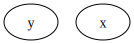

In [18]:
g = gr.Digraph()
g.node(name="y2", label="y")
g.node(name="x2", label="x")
g

The mutated DAG 3 is shown below. We can see that for this DAG, $P(y|\operatorname{do}(x=2)) = P(y|z)$. 

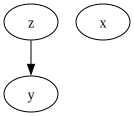

In [19]:
g = gr.Digraph()
g.node(name="z", label="z")
g.node(name="x", label="x")
g.node(name="y", label="y")
g.edge(tail_name="z", head_name="y")
g

$P(y|\operatorname{do}(x=2))$ for DAG 2 and DAG 3 will actually be the same in this contrived example because the details were arranged to arrive at the same marginal distribution $P(y)$ for all DAGs.

## Summary

Hopefuly, I've established a strong case for why we need to expand our skillset beyond the realm of Bayesian statistics alone. While these approaches are, and will always be, at the core of PyMC, the ecosystem is embracing causal reasoning.

In particular, we've seen how we can use the new $\operatorname{do}$ operator to implement realised or hypothetical interventions on causal models of the world to obtain interventional distributions. Understanding the underlying causal DAG and how interventions change this DAG are crucial components in building our understanding of causal reasoning.

The exciting thing is that there are many more causal reasoning ideas and concepts to learn. And PyMC is adapting as needed to support all your Bayesian causal inference needs.

Readers looking to learn more are suggested to check out the cited blog posts as well as textbooks, {cite:t}`pearl2000causality`, {cite:t}`pearl2016causal`, {cite:t}`mcelreath2018statistical`, {cite:t}`molak2023ciadip`.

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in July 2023

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Sun Feb 18 2024

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.18.1

pytensor: 2.18.6
xarray  : 2024.1.1

packaging : 23.2
matplotlib: 3.8.3
seaborn   : 0.13.2
numpy     : 1.26.4
graphviz  : 0.20.1
arviz     : 0.17.0
pymc      : 5.10.4

Watermark: 2.4.3



:::{include} ../page_footer.md :::